In [1]:
#install.packages(c("ggplot2", "gridExtra", "gtable", "grid", "tidyr", "dplyr", "data.table", "tidyverse", "forecast", "xts", "zoo"))

In [2]:
library(ggplot2)
library(gridExtra)
library(gtable)
library(grid)
library(tidyr)
library(dplyr)
library(data.table)
library(tidyverse)
library(forecast)
library(xts)
library(zoo)

Warning message:
"package 'gridExtra' was built under R version 3.6.3"Warning message:
"package 'gtable' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'data.table' was built under R version 3.6.3"
Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
<U+221A> tibble  3.0.1     <U+221A> stringr 1.4.0
<U+221A> readr   1.3.1     <U+221A> forcats 0.5.0
<U+221A> purrr   0.3.4  

# CZĘŚĆ PIERWSZA - PROGNOZA LICZBY NOWYCH LICENCJI WYKONYWANIA ZAWODU PIELĘGNIARKI I POŁOŻNEJ

Wczytano dane o strukturze liczbie wydanych uprawnień do wykonywania zawodu pielęgniarki i położnej z lat 2005-2018.

'data.frame':	14 obs. of  2 variables:
 $ date : Date, format: "2005-01-01" "2006-01-01" ...
 $ count: int  7219 7133 5280 5370 5186 4434 3510 3655 3480 4202 ...


date,count
2005-01-01,7219
2006-01-01,7133
2007-01-01,5280
2008-01-01,5370
2009-01-01,5186
2010-01-01,4434
2011-01-01,3510
2012-01-01,3655
2013-01-01,3480
2014-01-01,4202


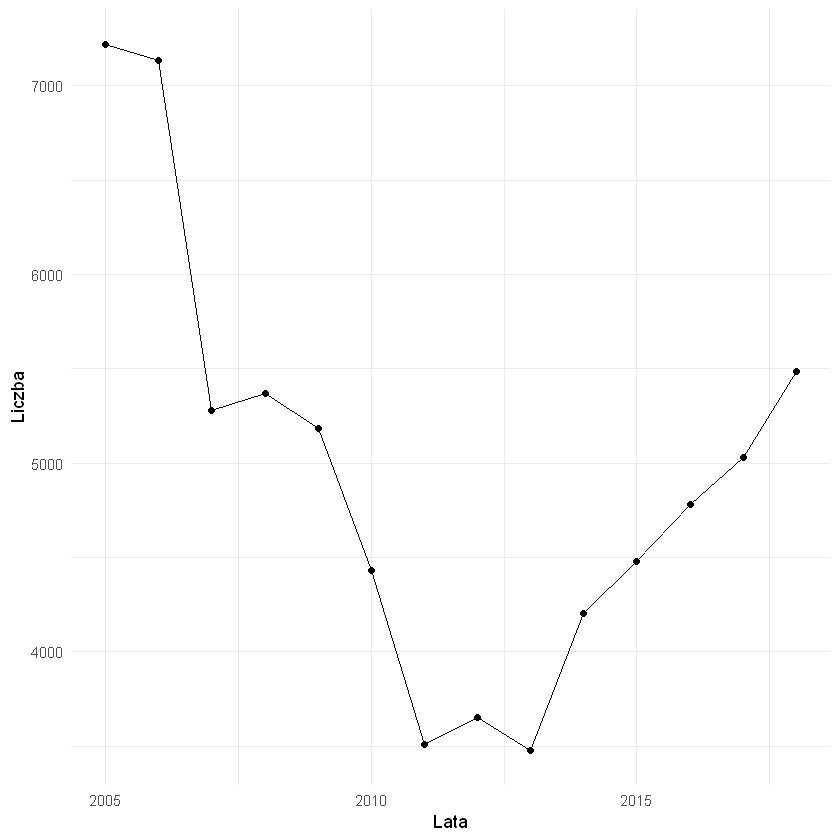

In [3]:
licences <- read.csv2('licences_given.csv')
licences$date <- as.Date(licences$date)
str(licences)

licences

ggplot(licences, aes(date, count)) +
geom_point() +
geom_line() +
xlab("Lata") +
ylab("Liczba") +
theme_minimal()

Stworzono szereg czsowy i dokonano interpolacji danych w przedziałach miesięcznych.

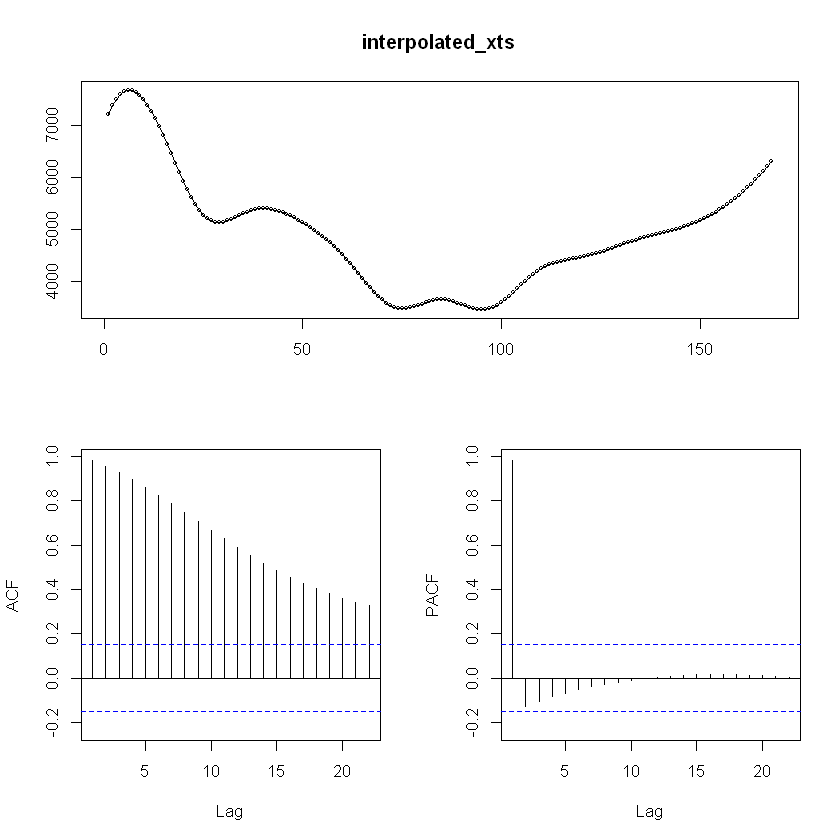

In [4]:
time <- as.POSIXct(licences$date, format = '%Y-%m-%d')
licences_xts <- xts(licences$count, order.by = time)
dates <- data.frame(format(seq(as.POSIXct("2005-01-01"), by="month", length.out=14*12), "%Y-%m-%d"))
colnames(dates) <- 'date'
dates$date <- as.Date(dates$date)
interpolated <- merge(x = dates, y = licences, by = "date", all = TRUE)
interpolated$date <- as.integer(interpolated$date)
interpolated <- data.frame(na.spline(interpolated, na.rm = FALSE))
interpolated$date <- as.Date(interpolated$date)
time <- as.POSIXct(interpolated$date, format = '%Y-%m-%d')
interpolated_xts <- xts(interpolated$count, order.by = time)
tsdisplay(interpolated_xts)

Wybór nalepszego modelu arima pod względem kryterium informacyjnego Akaikego.

In [5]:
licences_fit = auto.arima(interpolated_xts, ic = "aic", trace = TRUE)


 Fitting models using approximations to speed things up...

 ARIMA(2,2,2)                    : 222.9779
 ARIMA(0,2,0)                    : 1232.181
 ARIMA(1,2,0)                    : 616.0684
 ARIMA(0,2,1)                    : 1070.563
 ARIMA(1,2,2)                    : 342.4799
 ARIMA(2,2,1)                    : 221.1374
 ARIMA(1,2,1)                    : Inf
 ARIMA(2,2,0)                    : 251.6362
 ARIMA(3,2,1)                    : Inf
 ARIMA(3,2,0)                    : 224.9122
 ARIMA(3,2,2)                    : 213.0244
 ARIMA(4,2,2)                    : 220.1927
 ARIMA(3,2,3)                    : Inf
 ARIMA(2,2,3)                    : 224.8253
 ARIMA(4,2,1)                    : 225.2446
 ARIMA(4,2,3)                    : 206.5408
 ARIMA(5,2,3)                    : Inf
 ARIMA(4,2,4)                    : Inf
 ARIMA(3,2,4)                    : 231.504
 ARIMA(5,2,2)                    : Inf
 ARIMA(5,2,4)                    : Inf

 Now re-fitting the best model(s) without approxim

Sprawdzono trafność najlepszego modelu.

In [6]:
accuracy(licences_fit)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.03223938,0.9059078,0.3394591,-0.0002353032,0.006760883,6.891339e-05,-0.0933019


Wykonano test Ljunga-Boxa w celu sprawdzenia hipotezy o brak autokorelacji danych.

In [7]:
Box.test(residuals(licences_fit), lag=10, type="Ljung")
print("Nie ma podstaw do odrzucenia hipotezy zerowej o niezależności danych, gdyż p-value znacznie przekracza przyjęty poziom istotności 5%.")


	Box-Ljung test

data:  residuals(licences_fit)
X-squared = 3.5354, df = 10, p-value = 0.9659


[1] "Nie ma podstaw do odrzucenia hipotezy zerowej o niezależności danych, gdyż p-value znacznie przekracza przyjęty poziom istotności 5%."


Dokonano prognozy wartości na następne 12 lat (w ujęciu miesięcznym).

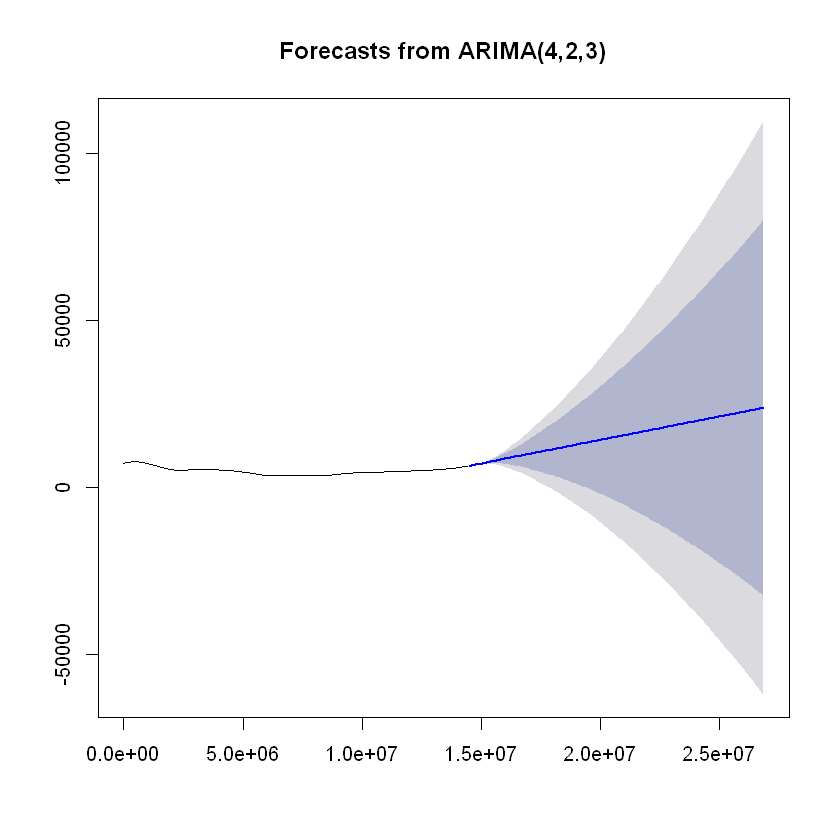

In [8]:
licences_forecast = forecast(licences_fit, h = 144)
plot(licences_forecast)

Zebrano wartności roczne (ze stycznia).

In [9]:
licences$date <- 2005:2018
licences$upper <- NA
licences$lower <- NA
licences$type <- "historyczne"

names(licences) <- c('years', 'mean', 'upper', 'lower', 'Typ')

licences_forcast <- data.frame(2018:2030, append(5487, licences_forecast$mean[c(1,13,25,37,49,61,73,85,97,109,121,133)]), append(5487, licences_forecast$upper[c(1,13,25,37,49,61,73,85,97,109,121,133)]), append(5487, licences_forecast$lower[c(1,13,25,37,49,61,73,85,97,109,121,133)]), "prognoza")

names(licences_forcast) <- c('years', 'mean', 'upper', 'lower', 'Typ')

inflow <- rbind(licences, licences_forcast)

inflow

years,mean,upper,lower,Typ
2005,7219.000,NA,NA,historyczne
2006,7133.000,NA,NA,historyczne
2007,5280.000,NA,NA,historyczne
2008,5370.000,NA,NA,historyczne
2009,5186.000,NA,NA,historyczne
2010,4434.000,NA,NA,historyczne
2011,3510.000,NA,NA,historyczne
2012,3655.000,NA,NA,historyczne
2013,3480.000,NA,NA,historyczne
2014,4202.000,NA,NA,historyczne


In [10]:
inflow[inflow$years >= 2024,]$lower <- 0

Warning message in max(ids, na.rm = TRUE):
"brak argumentów w max; zwracanie wartości -Inf"

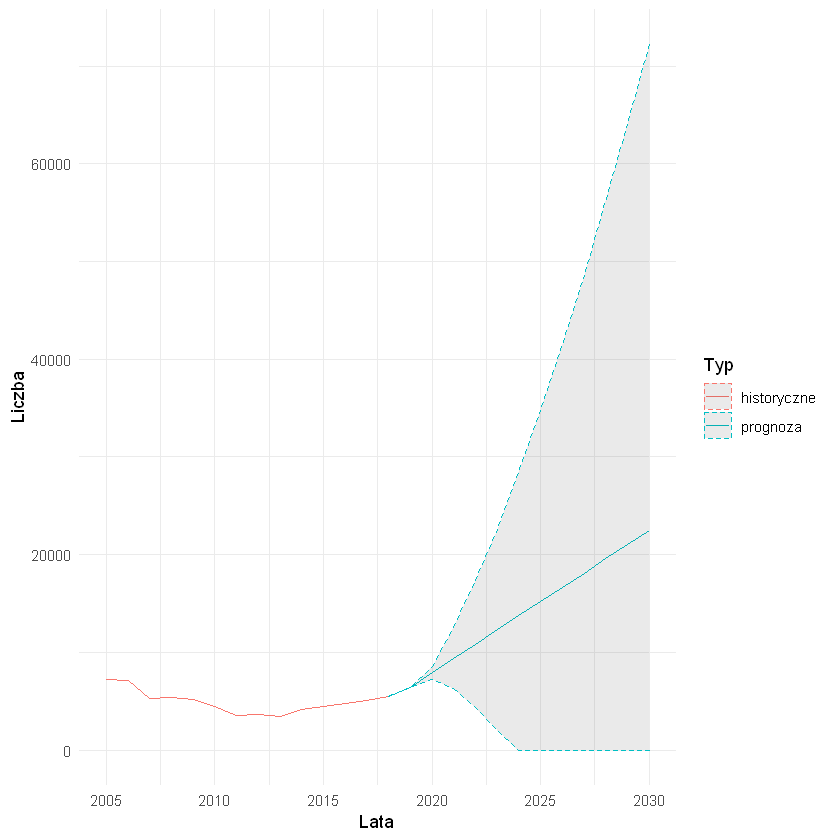

In [11]:
ggplot(inflow, aes(years, mean, color = Typ)) +
    geom_line() +
    geom_ribbon(aes(ymin= lower, ymax= upper), linetype=2, alpha=0.1) +
    theme_minimal() +
    xlab("Lata") +
    ylab("Liczba") +
    theme_minimal()

In [12]:
forecast_mean <- licences_forecast$mean[c(1,13,25,37,49,61,73,85,97,109,121,133)]
forecast_upper <- licences_forecast$upper[c(1,13,25,37,49,61,73,85,97,109,121,133)]
forecast_lower <- licences_forecast$lower[c(1,13,25,37,49,61,73,85,97,109,121,133)]

# CZĘSĆ DRUGA - PROGNOZA LICZBY PIELĘGNIAREK I POŁOŻNYCH W SKALI KRAJU

## Określenie struktury wiekowej pielęgniarek i położnych w wieku produkcyjnym na podstawie danych 

Wczytano dane o strukturze wiekowej pielęgniarek i położnych z roku 2018, stworzono z nich długą ramkę danych, dokonano ich czyszczenia i wizualizacji.

[1] "profession" "X88"        "X87"        "X86"        "X85"       
 [6] "X84"        "X83"        "X82"        "X81"        "X80"       
[11] "X79"        "X78"        "X77"        "X76"        "X75"       
[16] "X74"        "X73"        "X72"        "X71"        "X70"       
[21] "X69"        "X68"        "X67"        "X66"        "X65"       
[26] "X64"        "X63"        "X62"        "X61"        "X60"       
[31] "X59"        "X58"        "X57"        "X56"        "X55"       
[36] "X54"        "X53"        "X52"        "X51"        "X50"       
[41] "X49"        "X48"        "X47"        "X46"        "X45"       
[46] "X44"        "X43"        "X42"        "X41"        "X40"       
[51] "X39"        "X38"        "X37"        "X36"        "X35"       
[56] "X34"        "X33"        "X32"        "X31"        "X30"       
[61] "X29"        "X28"        "X27"        "X26"        "X25"       
[66] "X24"        "X23"        "X22"        "X21"

   profession      age            number      
 midwife:68   Min.   :21.00   Min.   :   0.0  
 nurse  :68   1st Qu.:37.75   1st Qu.: 187.8  
              Median :54.50   Median : 610.5  
              Mean   :54.50   Mean   :1874.3  
              3rd Qu.:71.25   3rd Qu.:1675.0  
              Max.   :88.00   Max.   :9064.0  

[1] 0.178071

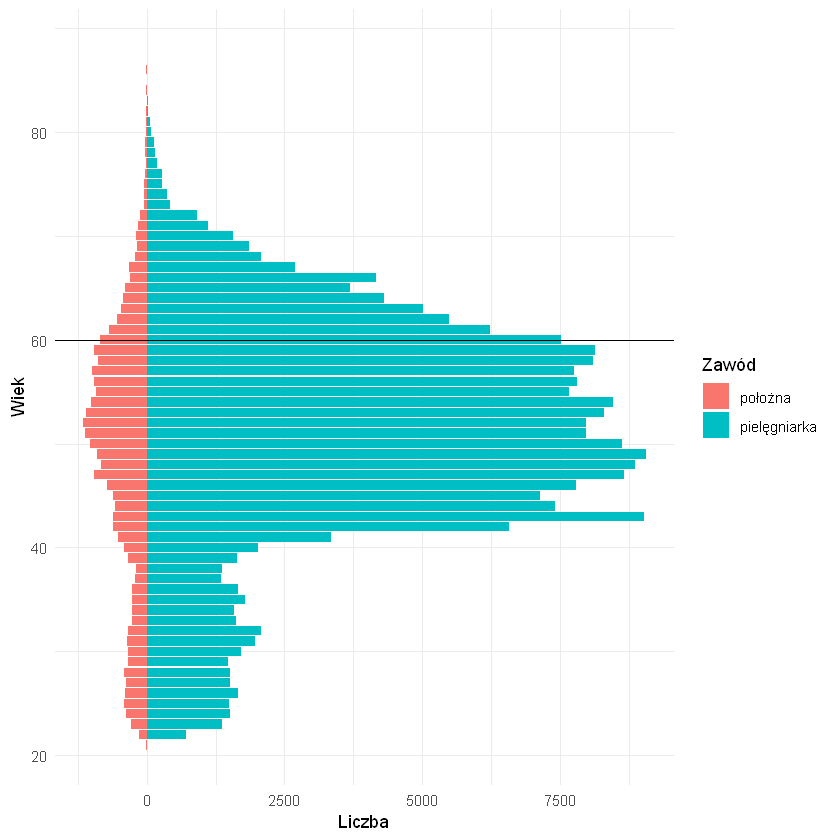

In [13]:
nurses <- read.csv2("data2018.csv")
names(nurses)
names(nurses) <- c("profession", "88":"21")
nurses <- gather(nurses, 'age', 'number',  -profession)
nurses$age <- as.numeric(nurses$age)
summary(nurses)


nurses_plot <- nurses
nurses_plot[nurses_plot$profession == 'midwife',]$number <- nurses_plot[nurses_plot$profession == 'midwife',]$number*(-1)

ggplot(nurses_plot, aes(x = age, y = number, fill = profession)) +
  geom_bar(stat="identity", position="identity")+
geom_vline(xintercept = 60) +
xlab("Wiek") +
ylab("Liczba") +
scale_fill_discrete(name = "Zawód", labels = c("położna", "pielęgniarka")) +
coord_flip() +
theme_minimal()

sum(nurses[nurses$age > '60',]$number)/sum(nurses$number)

Zagregowano dane dla pielęgniarek i położnych.

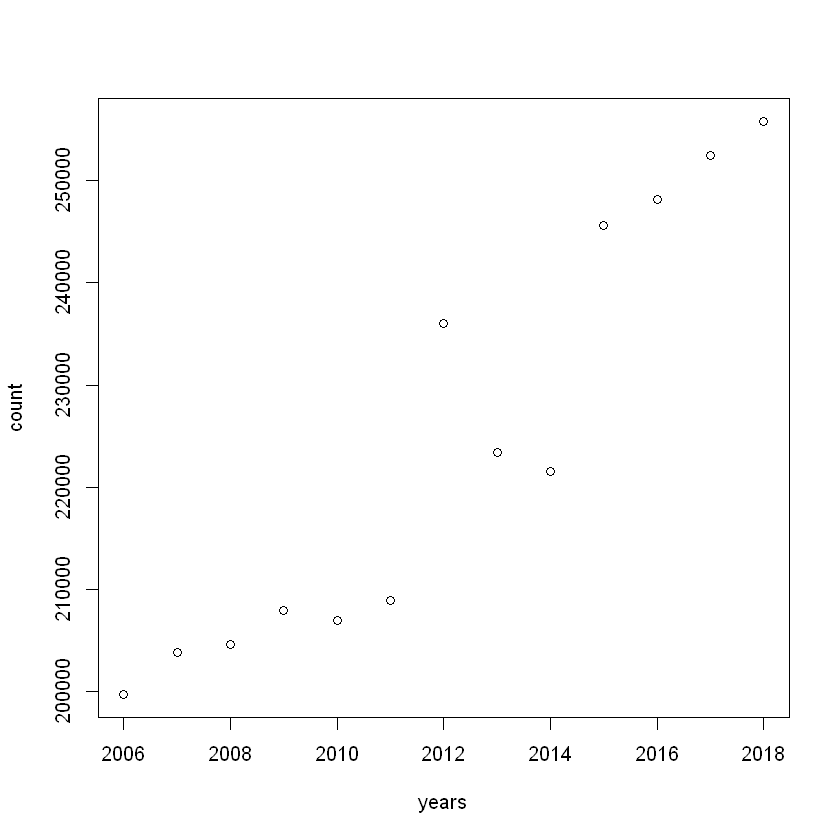

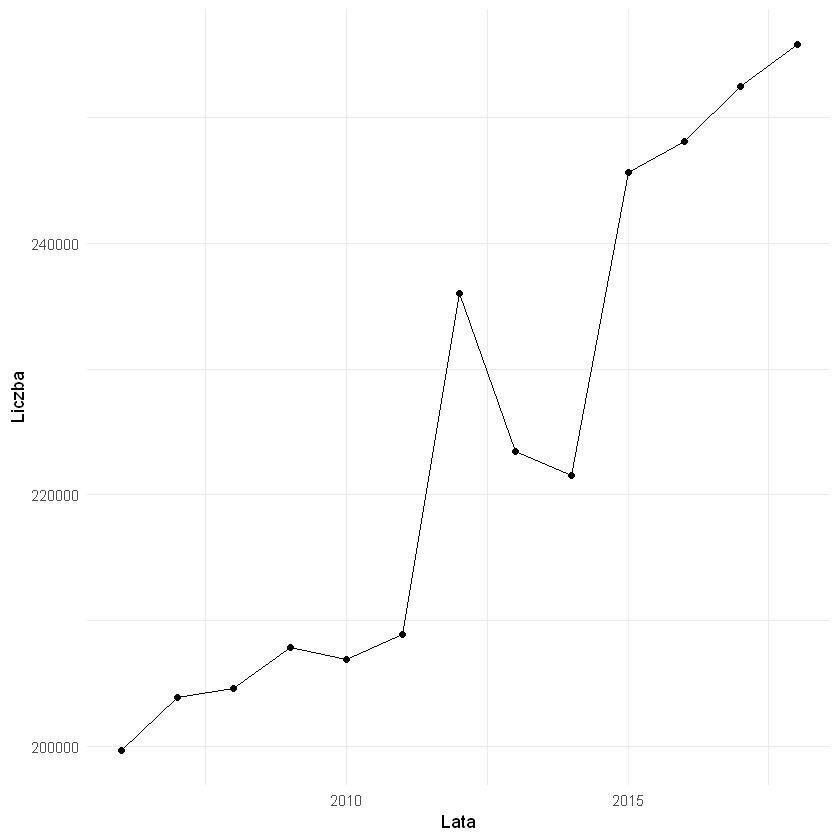

In [14]:
number <- data.frame(2006:2018, c(199700, 203849, 204586, 207892, 206941, 208867, 236006, 223420, 221569, 245625, 248111, 252426, 255805))
names(number) <- c('years', 'count')
plot(number)

ggplot(number, aes(years, count)) +
geom_point() +
geom_line() +
xlab("Lata") +
ylab("Liczba") +
theme_minimal()

In [15]:
nurses_1 <- aggregate(nurses$number, by = list(nurses$age), FUN = sum)
colnames(nurses_1) <- c('age', 'number')
head(nurses_1)

age,number
21,17
22,864
23,1654
24,1892
25,1905
26,2056


Wczytano tablice trwania życia

In [16]:
life_table <- read.csv2("life_table.csv")

In [17]:
life_table$death_prop_100k <- as.numeric(life_table$death_prop_100k)
life_table$death_prop <- life_table$death_prop_100k/100000
life_table$death_prop_100k <- NULL

In [18]:
head(life_table$death_prop)

[1] 0.00353 0.00020 0.00016 0.00012 0.00010 0.00008

Przypisano prawdopodobieństwo zgonu w danym roku dla danego wieku.

In [19]:
nurses_mean <- merge(x = life_table, y = nurses_1, by = 'age')
nurses_upper <- merge(x = life_table, y = nurses_1, by = 'age')
nurses_lower <- merge(x = life_table, y = nurses_1, by = 'age')

head(nurses_mean)
head(nurses_upper)


age,death_prop,number
21,0.00027,17
22,0.00025,864
23,0.00024,1654
24,0.00023,1892
25,0.00025,1905
26,0.00026,2056


age,death_prop,number
21,0.00027,17
22,0.00025,864
23,0.00024,1654
24,0.00023,1892
25,0.00025,1905
26,0.00026,2056


Funkcja pozwalająca przewidzieć liczbę pielęgniarek i położnych w n-tym roku.

In [20]:
mortality <- function(df, new, n) {
  x = df
  a = 1
  while (a <= n) {
    x$number <- round(x$number * (1-x$death_prop), 0)
    x[x$age == 60, 'number'] <- round(x[x$age == 60, 'number'] * (1-0.15),0)
    x[x$age == 61, 'number'] <- round(x[x$age == 61, 'number'] * (1-0.15),0)
    x[x$age == 62, 'number'] <- round(x[x$age == 62, 'number'] * (1-0.15),0)
    x[x$age == 63, 'number'] <- round(x[x$age == 63, 'number'] * (1-0.15),0)
    x[x$age == 64, 'number'] <- round(x[x$age == 64, 'number'] * (1-0.15),0)
    x[x$age == 65, 'number'] <- round(x[x$age == 65, 'number'] * (1-0.15),0)
    x[x$age == 66, 'number'] <- round(x[x$age == 66, 'number'] * (1-0.15),0)
    x[x$age == 67, 'number'] <- round(x[x$age == 67, 'number'] * (1-0.15),0)
    x[x$age == 68, 'number'] <- round(x[x$age == 68, 'number'] * (1-0.15),0)
    x[x$age == 69, 'number'] <- round(x[x$age == 69, 'number'] * (1-0.15),0)
    x[x$age == 70, 'number'] <- round(x[x$age == 70, 'number'] * (1-0.15),0)
    x[x$age == 71, 'number'] <- round(x[x$age == 71, 'number'] * (1-0.15),0)
    x[x$age == 72, 'number'] <- round(x[x$age == 72, 'number'] * (1-0.15),0)
    x[x$age == 73, 'number'] <- round(x[x$age == 73, 'number'] * (1-0.15),0)
    x[x$age == 74, 'number'] <- round(x[x$age == 74, 'number'] * (1-0.15),0)
    x[x$age == 75, 'number'] <- round(x[x$age == 75, 'number'] * (1-0.15),0)
    x[x$age == 76, 'number'] <- round(x[x$age == 76, 'number'] * (1-0.15),0)
    x[x$age == 77, 'number'] <- round(x[x$age == 77, 'number'] * (1-0.15),0)
    x[x$age == 78, 'number'] <- round(x[x$age == 78, 'number'] * (1-0.15),0)
    x[x$age == 79, 'number'] <- round(x[x$age == 79, 'number'] * (1-0.15),0)
    x[x$age == 80, 'number'] <- round(x[x$age == 80, 'number'] * (1-0.15),0)
    x[x$age == 81, 'number'] <- round(x[x$age == 81, 'number'] * (1-0.15),0)
    x[x$age == 82, 'number'] <- round(x[x$age == 82, 'number'] * (1-0.15),0)
    x[x$age == 83, 'number'] <- round(x[x$age == 83, 'number'] * (1-0.15),0)
    x[x$age == 84, 'number'] <- round(x[x$age == 84, 'number'] * (1-0.15),0)
    x[x$age == 85, 'number'] <- round(x[x$age == 85, 'number'] * (1-0.15),0)
    x[x$age == 86, 'number'] <- round(x[x$age == 86, 'number'] * (1-0.15),0)
    x[x$age == 87, 'number'] <- round(x[x$age == 87, 'number'] * (1-0.15),0)
    x[x$age == 88, 'number'] <- round(x[x$age == 88, 'number'] * (1-0.15),0)
    x$number <- lag(x$number, n = 1L)
    x[1,3] <- round(new[a] * rate[1],0)
    x[2,3] <- x[2,3] + round(new[a] * rate[2],0)
    x[3,3] <- x[3,3] + round(new[a] * rate[3],0)
    x[4,3] <- x[4,3] + round(new[a] * rate[4],0)
    x[5,3] <- x[5,3] + round(new[a] * rate[5],0)
    x[6,3] <- x[6,3] + round(new[a] * rate[6],0)
    x[7,3] <- x[7,3] + round(new[a] * rate[7],0)
    x[8,3] <- x[8,3] + round(new[a] * rate[8],0)
    x[9,3] <- x[9,3] + round(new[a] * rate[9],0)
    x[10,3] <- x[10,3] + round(new[a] * rate[10],0)
    a = a +1
  }
  return(x$number)
}

Zdecydowano o podziale liczby nowych licencji na 10 grup w wieku 20-29 lat zgodnie z rozkładem normalnym.

In [21]:
rate <- c(0.004, 0.019, 0.068, 0.161, 0.248, 0.249, 0.161, 0.068, 0.019, 0.004)

Założono, że jedynie połowa osób, które uzyskały prawo wykonywania zawodu pielęgniareki i położnej podejmie w nim pracę.

In [22]:
forecast_zero <- rep(0, 12)
nurses_zero <- nurses_mean

for (i in 1:length(forecast_zero)) {
  a <- mortality(nurses_zero, forecast_zero, i)
  nurses_zero <- cbind(nurses_zero, a)
  names(nurses_zero)[ncol(nurses_zero)] <- i
}

nurses_zero <- c( 
  sum(nurses_zero$'1'),
  sum(nurses_zero$'2'),
  sum(nurses_zero$'3'),
  sum(nurses_zero$'4'),
  sum(nurses_zero$'5'),
  sum(nurses_zero$'6'),
  sum(nurses_zero$'7'),
  sum(nurses_zero$'8'),
  sum(nurses_zero$'9'),
  sum(nurses_zero$'10'),
  sum(nurses_zero$'11'),
  sum(nurses_zero$'12')
)

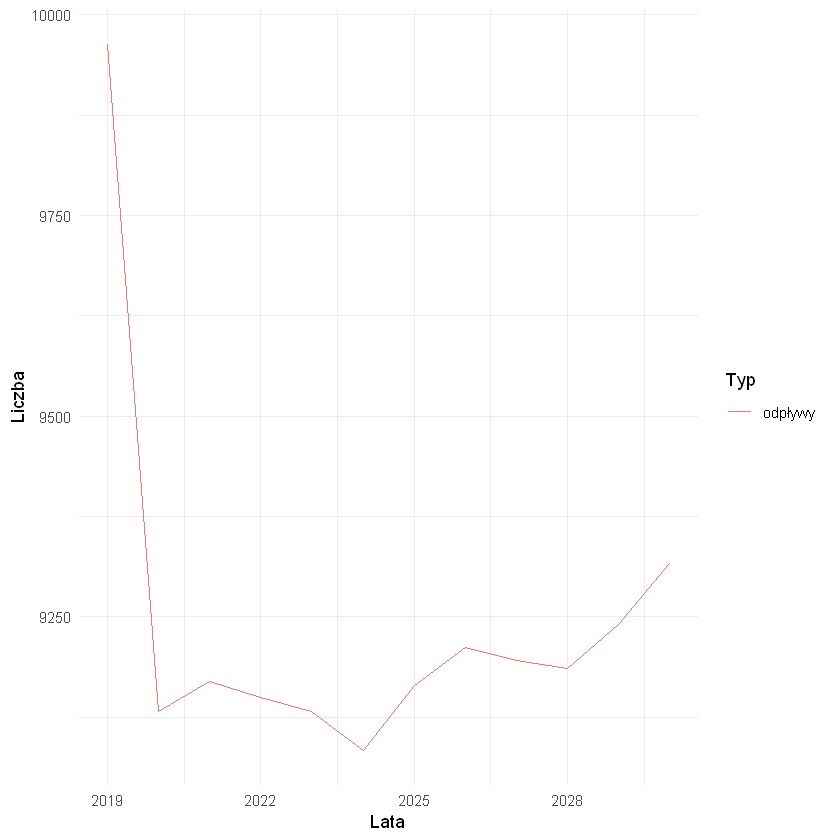

In [23]:
outflows <- data.frame(2018:2030, append(255805,(nurses_zero )), NA, NA, "odpływy")
names(outflows) <- c('years', 'mean', 'upper', 'lower', 'Typ')
outflows$lag <- lag(outflows$mean)
outflows$mean <- outflows$lag - outflows$mean
outflows$lag <- NULL


outflows <-  filter(outflows, outflows$years > 2018)

ggplot(outflows, aes(years, mean, color = Typ)) +
    geom_line() +
    theme_minimal() +
    xlab("Lata") +
    ylab("Liczba") +
    theme_minimal()

In [24]:
inflow

years,mean,upper,lower,Typ
2005,7219.000,NA,NA,historyczne
2006,7133.000,NA,NA,historyczne
2007,5280.000,NA,NA,historyczne
2008,5370.000,NA,NA,historyczne
2009,5186.000,NA,NA,historyczne
2010,4434.000,NA,NA,historyczne
2011,3510.000,NA,NA,historyczne
2012,3655.000,NA,NA,historyczne
2013,3480.000,NA,NA,historyczne
2014,4202.000,NA,NA,historyczne


In [25]:
inflow <- filter(inflow, inflow$years > 2018)

In [26]:
inflow$mean <- inflow$mean*0.5

In [27]:
inflow$upper <- inflow$upper*0.5

In [28]:
inflow$lower <- inflow$lower*0.5

In [29]:
inflow$Typ <- "dopływ"

In [30]:
inflow

years,mean,upper,lower,Typ
2019,3211.334,3211.931,3210.7378,dopływ
2020,3951.060,4296.294,3605.8261,dopływ
2021,4707.699,6276.530,3138.8681,dopływ
2022,5424.244,8665.805,2182.6828,dopływ
2023,6150.156,11305.964,994.3478,dopływ
2024,6879.361,14212.681,0.0000,dopływ
2025,7606.165,17363.783,0.0000,dopływ
2026,8333.184,20732.473,0.0000,dopływ
2027,9060.503,24302.901,0.0000,dopływ
2028,9787.700,28062.189,0.0000,dopływ


Warning message in max(ids, na.rm = TRUE):
"brak argumentów w max; zwracanie wartości -Inf"

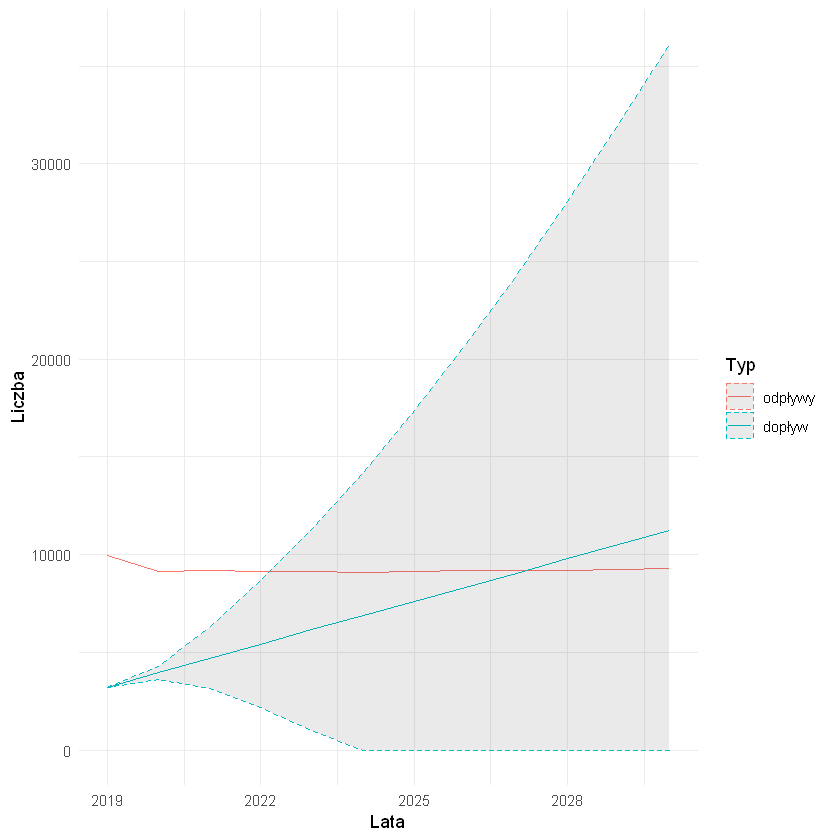

In [31]:
streams <- rbind(outflows, inflow)

ggplot(streams, aes(years, mean, color = Typ)) +
    geom_line() +
    geom_ribbon(aes(ymin= lower, ymax= upper), linetype=2, alpha=0.1) +
    theme_minimal() +
    xlab("Lata") +
    ylab("Liczba") +
    theme_minimal()

In [32]:
forecast_mean_1 <- round(forecast_mean * 0.5, 0)
forecast_upper_1 <- round(forecast_upper * 0.5, 0)
forecast_lower_1 <- round(forecast_lower * 0.5, 0)

Dokonano prognozy liczby pielęgniarek i położnych w skali kraju.

In [33]:
for (i in 1:length(forecast_mean_1)) {
  a <- mortality(nurses_mean, forecast_mean_1, i)
  nurses_mean <- cbind(nurses_mean, a)
  names(nurses_mean)[ncol(nurses_mean)] <- i
}

mean_number <- c( 
  sum(nurses_mean$'1'),
  sum(nurses_mean$'2'),
  sum(nurses_mean$'3'),
  sum(nurses_mean$'4'),
  sum(nurses_mean$'5'),
  sum(nurses_mean$'6'),
  sum(nurses_mean$'7'),
  sum(nurses_mean$'8'),
  sum(nurses_mean$'9'),
  sum(nurses_mean$'10'),
  sum(nurses_mean$'11'),
  sum(nurses_mean$'12')
)

In [34]:
mean_number

mean_number <- append(255805, mean_number)

[1] 249056 243878 239419 235698 232719 230518 228961 228081 227941 228535
[11] 229801 231714

In [35]:
for (i in 1:length(forecast_upper_1)) {
  a <- mortality(nurses_upper, forecast_upper_1, i)
  nurses_upper <- cbind(nurses_upper, a)
  names(nurses_upper)[ncol(nurses_upper)] <- i
}

upper_number <- c( 
  sum(nurses_upper$'1'),
  sum(nurses_upper$'2'),
  sum(nurses_upper$'3'),
  sum(nurses_upper$'4'),
  sum(nurses_upper$'5'),
  sum(nurses_upper$'6'),
  sum(nurses_upper$'7'),
  sum(nurses_upper$'8'),
  sum(nurses_upper$'9'),
  sum(nurses_upper$'10'),
  sum(nurses_upper$'11'),
  sum(nurses_upper$'12')
)

In [36]:
upper_number

upper_number <- append(255805, upper_number)

[1] 249057 244224 241337 240861 243041 248174 256381 267905 283013 301882
[11] 324630 351400

In [37]:
forecast_lower <- licences_forecast$lower[c(1,13,25,37,49,61,73,85,97,109,121,133)]

In [38]:
for (i in 1:length(forecast_lower_1)) {
  a <- mortality(nurses_lower, forecast_lower_1, i)
  nurses_lower <- cbind(nurses_lower, a)
  names(nurses_lower)[ncol(nurses_lower)] <- i
}

lower_number <- c( 
  sum(nurses_lower$'1'),
  sum(nurses_lower$'2'),
  sum(nurses_lower$'3'),
  sum(nurses_lower$'4'),
  sum(nurses_lower$'5'),
  sum(nurses_lower$'6'),
  sum(nurses_lower$'7'),
  sum(nurses_lower$'8'),
  sum(nurses_lower$'9'),
  sum(nurses_lower$'10'),
  sum(nurses_lower$'11'),
  sum(nurses_lower$'12')
)

In [39]:
lower_number

lower_number <- append(255805, lower_number)

[1] 249056 243532 237503 230535 222398 212856 201538 188257 172873 155192
[11] 134972 112027

Dokonano wizualizacji danych.

Warning message in max(ids, na.rm = TRUE):
"brak argumentów w max; zwracanie wartości -Inf"

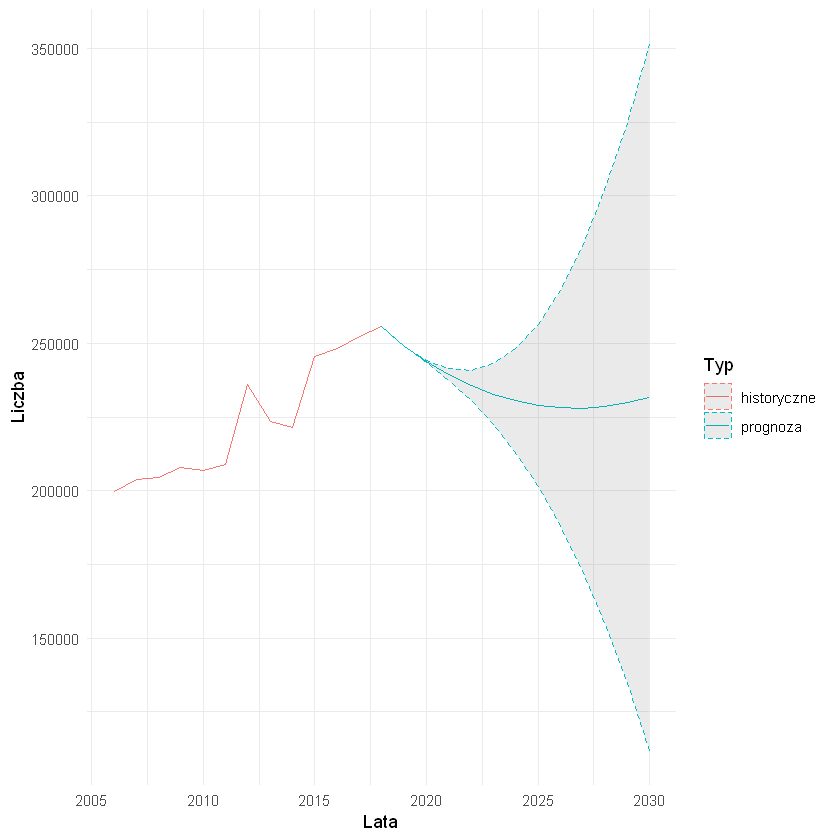

In [40]:
h <- data.frame(2006:2018, c(199700, 203849, 204586, 207892, 206941, 208867, 236006, 223420, 221569, 245625, 248111, 252426, 255805),NA,NA,'historyczne')
names(h) <- c('years', 'mean', 'lower', 'upper', 'Typ')
f <- data.frame(2018:2030, mean_number, lower_number, upper_number, 'prognoza')
names(f) <- c('years', 'mean', 'lower', 'upper', 'Typ')

to_plot <- rbind(h, f)

ggplot(to_plot, aes(years, mean, color = Typ)) +
    geom_line() +
    geom_ribbon(aes(ymin= lower, ymax= upper), linetype=2, alpha=0.1) +
    theme_minimal() +
    xlab("Lata") +
    ylab("Liczba") +
    theme_minimal()
    